In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from tqdm import tqdm_notebook
from itertools import product
def mean_absolute_percentage_error(y_true,y_pred):
    return np.mean(np.abs(((y_true-y_pred)/y_true)))*100
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 
from sklearn.metrics import r2_score,mean_absolute_error,median_absolute_error,mean_squared_error,mean_squared_log_error

In [2]:
df=pd.read_csv('C:/Users/Acer/OneDrive/Desktop/FINAL YEAR/FINAL YEARR/Final Dataset.csv')

In [3]:
df['Datetime'] = pd.to_datetime(df['Datetime'])

In [4]:
df['Datetime']=pd.to_datetime(df['Datetime'],format=('%Y-%m-%d'))

In [5]:
df.index=df['Datetime']

In [6]:
df=df.drop(columns='Datetime')

In [7]:
df

,BESCOM
Datetime,
2018-01-01 00:00:00,211786.8638
2018-01-01 01:00:00,204022.4531
2018-01-01 02:00:00,198376.1782
2018-01-01 03:00:00,198870.6240
2018-01-01 04:00:00,201310.4045
...,...
2019-12-31 19:00:00,248972.7234
2019-12-31 20:00:00,232655.9861
2019-12-31 21:00:00,226721.6016


In [8]:
df_daily=df.resample('D').sum()

In [9]:
df_daily

,BESCOM
Datetime,
2018-01-01,5.465430e+06
2018-01-02,5.785545e+06
2018-01-03,5.898176e+06
2018-01-04,5.992804e+06
2018-01-05,6.069460e+06
...,...
2019-12-27,6.099080e+06
2019-12-28,5.907196e+06
2019-12-29,5.361519e+06


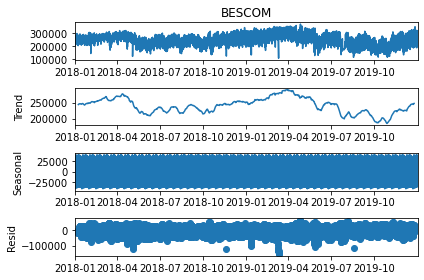

In [10]:
import statsmodels.api as sm
res = sm.tsa.seasonal_decompose(df.BESCOM.interpolate(),freq=360,model='additive')
resplot = res.plot()


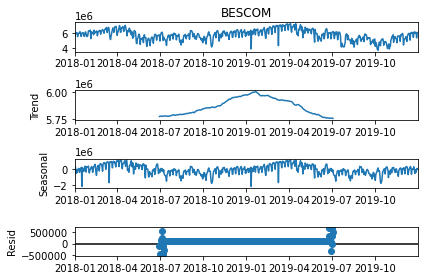

In [11]:
import statsmodels.api as sm
res = sm.tsa.seasonal_decompose(df_daily.BESCOM.interpolate(),freq=360,model='additive')
resplot = res.plot()


In [12]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.BESCOM.dropna())

print('p-value: %f' % result[1])

p-value: 0.000000


In [13]:
import itertools
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [14]:
# Split into train and test set
train_data = df[:13140] 
# train_data_log = np.log10(train_data)
test_data = df[13140:] 

In [15]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

In [16]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        try:
            temp_model = sm.tsa.statespace.SARIMAX(train_data,
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=True)
            results = temp_model.fit()

            
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(1, 1, 0)x(1, 1, 0, 12)12 model - AIC:6.0


In [17]:
best_model = sm.tsa.statespace.SARIMAX(train_data,
                                      order=(0, 1, 0),
                                      seasonal_order=(1, 1, 0, 12),
                                      enforce_stationarity=True)
best_results = best_model.fit()

In [18]:
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_sarima=sm.tsa.statespace.SARIMAX(df['BESCO[M'],order=(1, 1, 0),seasonal_order=(1, 1, 0, 12))
model=model_sarima.fit()

In [19]:
print(best_results.summary().tables[0])
print(best_results.summary().tables[1])


                                     SARIMAX Results                                      
Dep. Variable:                             BESCOM   No. Observations:                13140
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 12)   Log Likelihood             -137155.310
Date:                            Wed, 09 Jun 2021   AIC                         274314.620
Time:                                    17:11:18   BIC                         274329.585
Sample:                                01-01-2018   HQIC                        274319.618
                                     - 07-02-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.8539      0.001   -799.023      0.000      -0.856      -0.852
sigma2      6.683e+07   6.44e-12   

Text(0, 0.5, 'Energy Consumption')

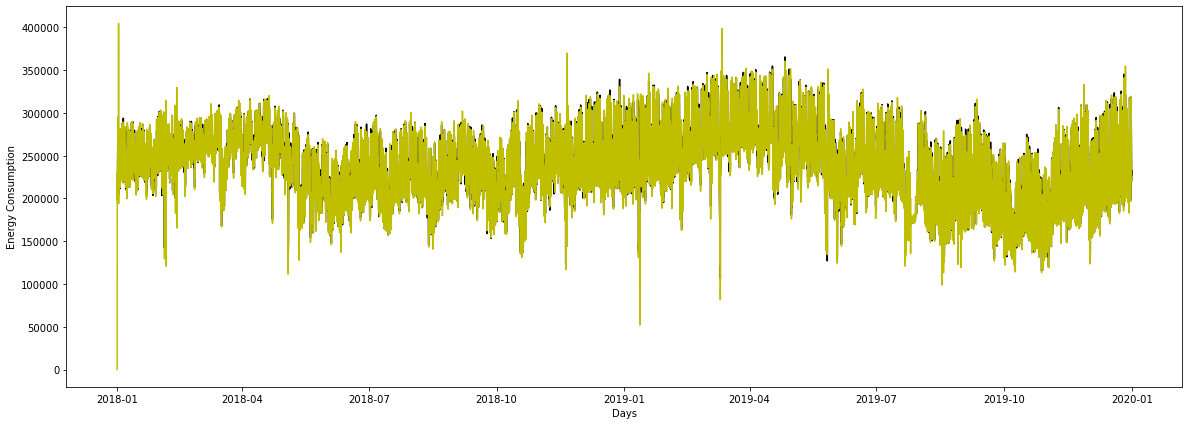

In [20]:
plt.figure(figsize=(20,7))
plt.plot(df.BESCOM,'black')
plt.plot(model.fittedvalues,'y')
plt.xlabel('Days')
plt.ylabel('Energy Consumption')

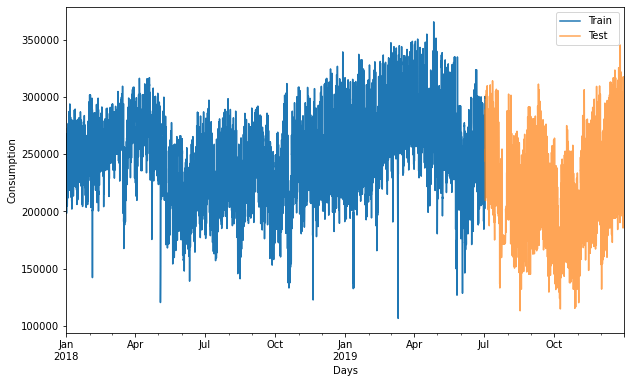

In [40]:
axis = train_data['BESCOM'].plot(label='Train ', figsize=(10, 6))
testCopy['BESCOM'].plot(ax=axis, label='Test ', alpha=0.7)

axis.set_xlabel('Days')
axis.set_ylabel('Consumption')
plt.legend(loc='best')
plt.show()
plt.close()

In [46]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('2019-07-01'), dynamic=True, full_results=True)

In [47]:
pred_dynamic_ci = pred_dynamic.conf_int()

In [48]:
pred99 = best_results.get_forecast(steps=6, alpha=0.1)

In [49]:
pred99.predicted_mean

2019-07-02 12:00:00    299440.016909
2019-07-02 13:00:00    291632.921781
2019-07-02 14:00:00    295452.777049
2019-07-02 15:00:00    287472.661880
2019-07-02 16:00:00    277905.103394
2019-07-02 17:00:00    270741.111091
Freq: H, Name: predicted_mean, dtype: float64

In [50]:
# Extract the predicted and true values of our time series
ts_forecasted = pred_dynamic.predicted_mean
testCopy = test_data.copy()
testCopy['ts_forecasted'] =  pred99.predicted_mean

In [51]:
testCopy.head(6)

,BESCOM,ts_forecasted
Datetime,,
2019-07-02 12:00:00,288320.5537,299440.016909
2019-07-02 13:00:00,284338.5137,291632.921781
2019-07-02 14:00:00,283862.9692,295452.777049
2019-07-02 15:00:00,280168.0137,287472.661880
2019-07-02 16:00:00,266369.2939,277905.103394
2019-07-02 17:00:00,249377.6875,270741.111091


In [28]:
def mean_absolute_percentage_error(y_true,y_pred):
    return np.mean(np.abs(((y_true-y_pred)/y_true)))*100

In [29]:
print(mean_absolute_percentage_error(df.BESCOM,model.fittedvalues))

2.010983889855052


In [30]:
fcast = model.get_prediction(start=13140, end=len(df))
df_p = fcast.predicted_mean
df_ci = fcast.conf_int()

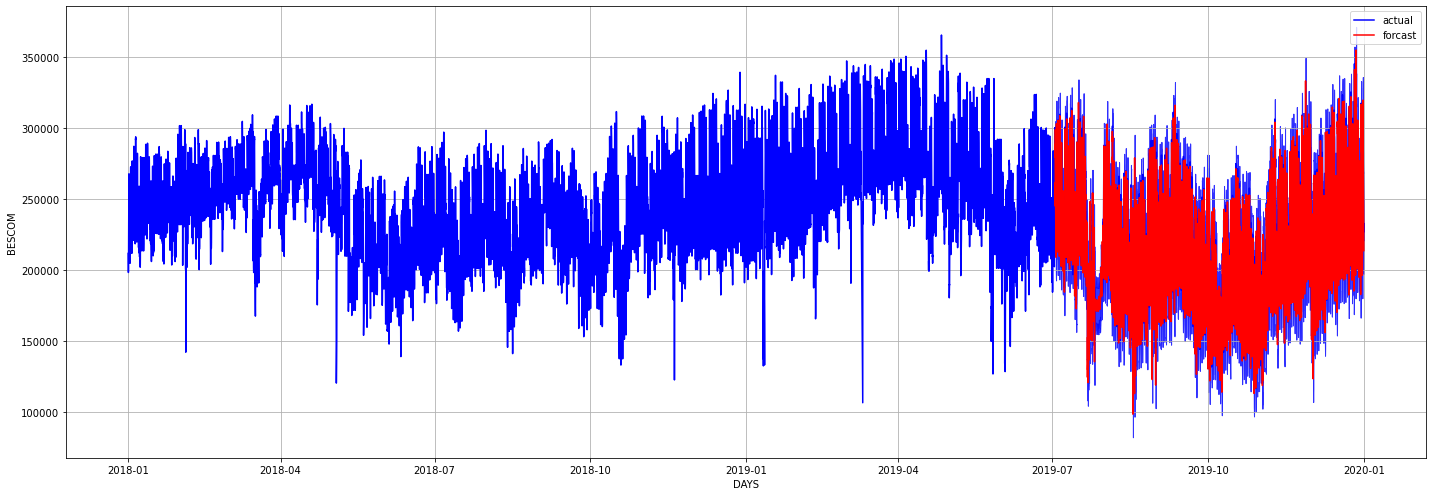

In [31]:
plt.figure(figsize=(20,7))

plt.fill_between(df_ci.index[1:],
                df_ci.iloc[1:, 0],
                df_ci.iloc[1:, 1], color='b', alpha=.8)
plt.plot(df,color='blue',label='actual')
plt.plot(df_p,label='forcast',color='red')


plt.xlabel('DAYS')
plt.ylabel('BESCOM')
plt.legend()
plt.tight_layout()
plt.grid()

plt.show()

In [32]:
dates=['2020-01-01 00:00:00', '2020-01-01 01:00:00', '2020-01-01 02:00:00', '2020-01-01 03:00:00', '2020-01-01 04:00:00']

In [33]:
future_dates=pd.DataFrame(dates)

In [34]:
future_dates=future_dates.rename(columns={0:'Date'})

In [35]:
future_dates['Date']=pd.to_datetime(future_dates['Date'])

In [36]:
bescom_predicted = model.predict(start=pd.to_datetime('2020-01-01 01:00:00'), end= pd.to_datetime('2020-01-01 07:00:00')).to_frame().rename(columns = {0:'Energy'})

In [37]:
bescom_predicted #Future predicted values :D

,predicted_mean
2020-01-01 01:00:00,206671.825500
2020-01-01 02:00:00,201248.035623
2020-01-01 03:00:00,199926.625439
2020-01-01 04:00:00,200689.897506
2020-01-01 05:00:00,206939.810381
2020-01-01 06:00:00,211941.631218
2020-01-01 07:00:00,245644.981586
